# ChainerRLによる深層強化学習

##本チュートリアルではchainerRLを利用して深層強化学習(Deep Q-Network)の実装を確認，学習および評価を行います．　環境としてはGoogle が提供する Google Colaboratory上でおこないます． GPU上で処理を行うため，colaboratoryの[ランタイム]->[ランタイムのタイプを変更]からハードウェアアクセラレータをGPUにしてください．


Goolge Colaboratory上にChainerとChainerRL，強化学習環境のgymをインストールします．c

In [1]:
!curl https://colab.chainer.org/install | sh -
!pip -q install chainerrl
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   8404      0 --:--:-- --:--:-- --:--:--  8404
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!
    100% |████████████████████████████████| 92kB 5.6MB/s 


Chainerで深層強化学習のネットワークを学習するために必要なモジュールや関数をインポートします．

In [ ]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

ChainerRLはOpenAI Gymから提供されているゲームなどの環境を利用できます．
環境から現在の状態を簡単に取得できます．
resetで環境を初期化できます．stepで与えたactionにより環境を変化させます．
そして，renderで次の状態をレンダリングします．
ここでは，環境として，CartPole-v0を利用します．これは，倒立振子というポールを直立させ続けるように左右に移動するタスクです

In [3]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
#env.render()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

observation space: Box(4,)
action space: Discrete(2)
initial observation: [ 0.00533034  0.04569254 -0.04945244 -0.04962281]
next observation: [ 0.00624419 -0.14868671 -0.0504449   0.22705652]
reward: 1.0
done: False
info: {}


次に，エージェントとなるネットワークモデルを定義します．
ここでは，３層のニューラルネットワークを利用します．

In [ ]:
class QFunction(chainer.Chain):

    def __init__(self, obs_size, n_actions, n_hidden_channels=50):
        super().__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_hidden_channels)
            self.l1 = L.Linear(n_hidden_channels, n_hidden_channels)
            self.l2 = L.Linear(n_hidden_channels, n_actions)

    def __call__(self, x, test=False):
        """
        Args:
            x (ndarray or chainer.Variable): An observation
            test (bool): a flag indicating whether it is in test mode
        """
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l1(h))
        return chainerrl.action_value.DiscreteActionValue(self.l2(h))

obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)

GPUで学習を行うためにネットワークモデルをGPUに転送します


In [5]:
q_func.to_gpu(0)

ネットワークから行動を出力するようにします

In [ ]:
_q_func = chainerrl.q_functions.FCStateQFunctionWithDiscreteAction(
    obs_size, n_actions,
    n_hidden_layers=2, n_hidden_channels=50)

最適化の方法としてAdamを利用します．

In [7]:
# Use Adam to optimize q_func. eps=1e-2 is for stability.
optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

探索方法（εグリーディ探索），リプレイバッファなどの設定を行います．また，学習するエージェントはDouble DQNとします．

In [ ]:
# Set the discount factor that discounts future rewards.
gamma = 0.95

# Use epsilon-greedy for exploration
explorer = chainerrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.3, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

# Since observations from CartPole-v0 is numpy.float64 while
# Chainer only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(np.float32, copy=False)

# Now create an agent that will interact with the environment.
agent = chainerrl.agents.DQN(
    q_func, optimizer, replay_buffer, gamma, explorer,
    replay_start_size=500, update_interval=1,
    target_update_interval=100, phi=phi)

学習を開始します．

In [9]:
n_episodes = 200
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done and t < max_episode_len:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics())
    agent.stop_episode_and_train(obs, reward, done)
print('Finished.')

episode: 10 R: 51.0 statistics: [('average_q', 0.02111608221291556), ('average_loss', 0), ('n_updates', 0)]
episode: 20 R: 29.0 statistics: [('average_q', 0.5712712763417326), ('average_loss', 0.10775510706091775), ('n_updates', 350)]
episode: 30 R: 44.0 statistics: [('average_q', 2.264351221079798), ('average_loss', 0.10461999805621425), ('n_updates', 789)]
episode: 40 R: 49.0 statistics: [('average_q', 4.368018049070401), ('average_loss', 0.16685244593919688), ('n_updates', 1224)]
episode: 50 R: 96.0 statistics: [('average_q', 7.398279809637288), ('average_loss', 0.1914119322067214), ('n_updates', 1890)]
episode: 60 R: 122.0 statistics: [('average_q', 10.85561206562019), ('average_loss', 0.2320410130727667), ('n_updates', 2730)]
episode: 70 R: 181.0 statistics: [('average_q', 15.00657642638385), ('average_loss', 0.18138210599519797), ('n_updates', 4189)]
episode: 80 R: 193.0 statistics: [('average_q', 18.00077092347954), ('average_loss', 0.19724079689470228), ('n_updates', 5906)]
epi

学習した結果を確認します．

In [10]:
#!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
#!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt-get -q install xvfb python-opengl ffmpeg

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,682 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.2 [783 kB]
Fetched 1,280 kB in 2s (653 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 131284 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.2_amd64.deb ...


In [ ]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)


test episode: 0 R: 189.0
test episode: 1 R: 200.0
test episode: 2 R: 200.0


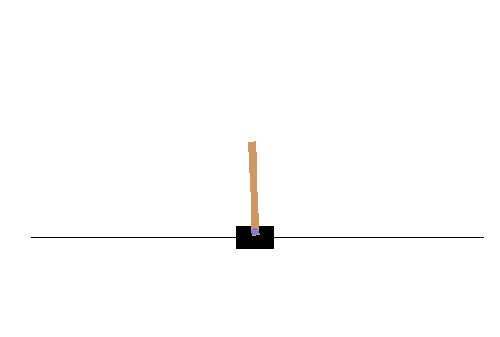

In [12]:
frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        action = agent.act(obs)
        obs, r, done, _ = env.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

結果の動画を作成します．

In [ ]:

# wrap env for recording video
envw = gym.wrappers.Monitor(env, "./", force=True)

for i in range(3):
    obs = envw.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        envw.render()
        action = agent.act(obs)
        obs, r, done, _ = envw.step(action)
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
    agent.stop_episode()

DependencyNotInstalled: ignored

動画をダウンロードします

In [ ]:
from google.colab import files
import glob

for file in glob.glob("openaigym.video.*.mp4"):
  files.download(file)

学習したモデルを保存します．

In [ ]:
# Save an agent to the 'agent' directory
agent.save('agent')

# Uncomment to load an agent from the 'agent' directory
# agent.load('agent')